# More tuning

In [1]:
import nbloader
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow.contrib.slim as slim
from demo_process import *
print ("Packages loaded.")

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Packages loaded.


#### Preprocess data

In [2]:
dirPath = '../data'
id2idx,nTotalTxt,nTotalChildren = get_unique_idx(_dirPath=dirPath,_VERBOSE=False)
totalFeats,trajList,uniqueChildIdxList,titleList \
    = preprocess_traj(_dirPath=dirPath,_nTotalTxt=nTotalTxt
                    ,_nTotalChildren=nTotalChildren,_id2idx=id2idx
                    ,_VERBOSE=False,_PLOT_SMOOTHED_TRAJ=False)
print ("Preprocess done.")

Preprocess done.


#### Animate (takes time)

In [3]:
ANIMATE_TRAJ = False
if ANIMATE_TRAJ:
    fIdx,nTick = 0,100 
    frames = make_frames(_traj=trajList[fIdx]
                         ,_uniqueChildList=uniqueChildIdxList[fIdx],_nTick=nTick)
    animate_frames(_frames=frames,_figsize=(8,8),_title=titleList[fIdx])

#### Test classification results

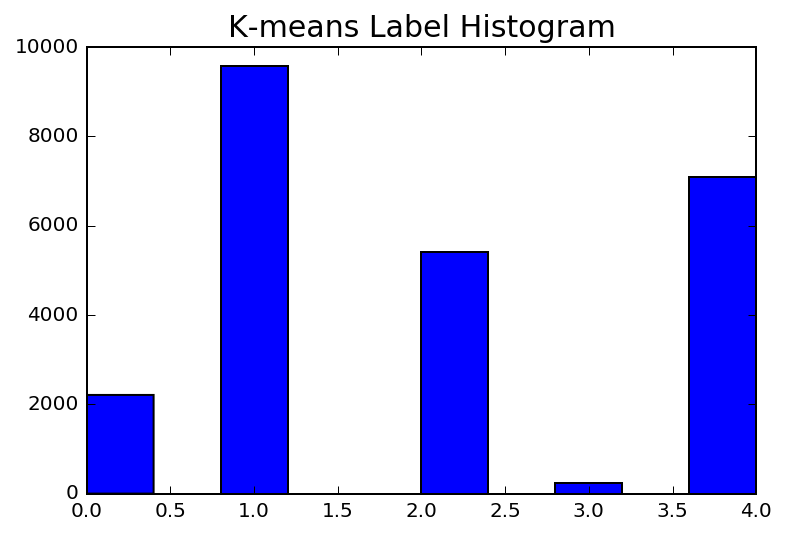

[xgboost] Avg accr:60.32% ([0.611 0.5   0.389 0.5   0.722 0.722 0.778])


In [4]:
nCluster,chunkSec,reduceDim  = 5,10,10 # 5,10,5:60% / 
nTrain = 40 # Use 40 children for traning, 18 for testing
surveyRes = get_surveyRes()
nzrFeat,nzdTotalFeats = get_noramlized_feat(totalFeats,_VERBOSE=False)
chunks_total = split_trajs(nzdTotalFeats,chunkSec,_VERBOSE=False)
nTest = len(chunks_total) - nTrain
centers,Ured,labels = reduce_dim_n_cluster(chunks_total,reduceDim,nCluster
                                    ,nTrain,nTest,_VERBOSE=False,_PLOT_HIST=True)
featHistTotal = get_featHist(chunks_total,centers,Ured,nCluster,_VERBOSE=False)
xTrain,yTrain = featHistTotal[:nTrain,:],surveyRes[:nTrain,:]
xTest,yTest = featHistTotal[nTrain:,:],surveyRes[nTrain:,:]
avgAccr,accuracy_list = run_xgboost(xTrain,yTrain,xTest,yTest,surveyRes.shape[1]
                ,_VERBOSE=False,_eta=0.1,_gamma=10,_max_depth=5,_num_round=50
                ,_min_child_weight=3,_colsample_bytree=0.7)
np.set_printoptions(precision=3)
print ("[xgboost] Avg accr:%.2f%% (%s)"%(avgAccr*100,accuracy_list))

#### Show what K-means centers actually look like

In [5]:
X = np.matmul(centers,Ured.T)
for i in range(5):
    print ("[%d-th] Cluster mean"%(i))
    print nzrFeat.get_orgval(X[i,:].reshape(10,6))
    print

[0-th] Cluster mean
[[1243.674 1729.017 2075.172 2332.43  2562.912  885.238]
 [1273.381 1760.707 2107.288 2361.34  2588.185  861.151]
 [1286.928 1781.709 2129.252 2380.539 2608.173  929.437]
 [1294.274 1795.043 2139.382 2392.925 2623.304  923.136]
 [1294.605 1796.841 2143.916 2401.344 2632.031  910.36 ]
 [1296.665 1795.946 2141.316 2399.328 2628.466  926.919]
 [1293.754 1793.622 2141.68  2397.495 2625.754  914.427]
 [1289.823 1785.844 2129.318 2386.932 2616.662  928.824]
 [1278.039 1768.921 2112.256 2371.651 2601.586  924.754]
 [1245.751 1734.24  2080.597 2341.29  2574.234  911.993]]

[1-th] Cluster mean
[[ 496.895  786.102 1027.094 1246.274 1455.467 1699.101]
 [ 491.44   781.231 1022.159 1240.736 1449.818 1723.316]
 [ 486.725  775.908 1017.058 1235.412 1444.02  1723.755]
 [ 484.17   773.316 1014.503 1232.047 1439.934 1699.282]
 [ 484.481  773.969 1015.016 1232.044 1439.507 1678.224]
 [ 486.344  776.229 1017.593 1234.74  1442.154 1698.906]
 [ 489.507  779.708 1020.41  1238.518 1445.628

#### Plot centers

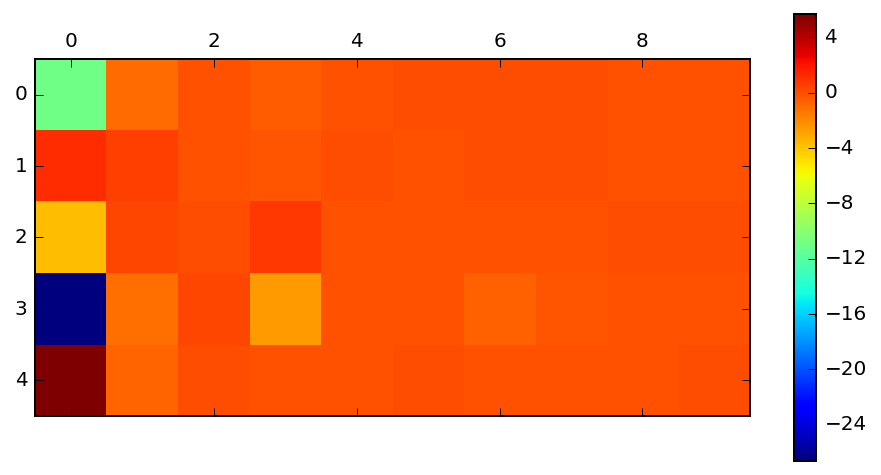

In [6]:
plt.matshow(centers)
plt.colorbar()

#### Classification with deep learning

In [7]:
def gpusession(): 
    config = tf.ConfigProto(); 
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess
class mlp_cls_class(object):
    def __init__(self,_name='basic_mlp',_xdim=5,_ydim=3,_hdims=[16,16]
                 ,_actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-5
                 ,_VERBOSE=True):
        self.name = _name
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdims = _hdims
        self.actv = _actv
        self.bn = _bn
        self.l2_reg_coef = _l2_reg_coef
        self.VERBOSE = _VERBOSE
        # Build model
        self.build_model()
        # Build graph
        self.build_graph()
        # Check parameters
        self.check_params()
        
    def build_model(self):
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim]) # Input [N x xdim]
        self.t = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim]) # Output [N x D]
        self.kp = tf.placeholder(dtype=tf.float32,shape=[])
        self.is_training = tf.placeholder(dtype=tf.bool,shape=[]) # []
        self.lr = tf.placeholder(dtype=tf.float32,shape=[]) # []
        with tf.variable_scope(self.name,reuse=False) as scope:
            # Input
            self.layers = []
            self.layers.append(self.x)
            _net = self.x
            # Intermediate layers
            for hidx,hdim in enumerate(self.hdims):
                _net = slim.fully_connected(_net,hdim,activation_fn=self.actv,scope=('linear_%d'%(hidx)))
                self.layers.append(_net)
            # Dropout
            _net = slim.dropout(_net,keep_prob=self.kp,is_training=self.is_training,scope='dropout')  
            self.layers.append(_net)
            # Output layer
            self.out = slim.fully_connected(_net,self.ydim,activation_fn=None,scope='out')
            self.layers.append(self.out)
    
    def build_graph(self):
        # Cross-entropy loss
        self._loss_ce = tf.nn.softmax_cross_entropy_with_logits(labels=self.t,logits=self.out) # [N]
        self.loss_ce = tf.reduce_mean(self._loss_ce) # []
        # Weight decay regularizer
        _g_vars = tf.global_variables()
        _c_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        self.l2_reg = self.l2_reg_coef*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in _c_vars])) # []
        # Total loss
        self.loss_total = self.loss_ce + self.l2_reg
        self.optm = tf.train.AdamOptimizer(learning_rate=self.lr
                                           ,beta1=0.9,beta2=0.999,epsilon=1e-9).minimize(self.loss_total)
        # Accuracy
        _corr = tf.equal(tf.argmax(self.out, 1), tf.argmax(self.t, 1))    
        self.accr = tf.reduce_mean(tf.cast(_corr,tf.float32)) 
        
    # Check parameters
    def check_params(self):
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        if self.VERBOSE:
            print ("==== Global Variables ====")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name 
            w_shape = self.g_vars[i].get_shape().as_list()
            if self.VERBOSE:
                print (" [%02d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
        # Print layers
        if self.VERBOSE:
            print ("====== Layers ======")
            nLayers = len(self.layers)
            for i in range(nLayers):
                print (" [%02d/%d] %s %s"%(i,nLayers,self.layers[i].name,self.layers[i].shape))
    

#### Train with (xTrain,yTrain,xTest,yTest)

In [8]:
_xTrain = np.copy(xTrain)
_yTrain = np.copy(yTrain)
_xTest = np.copy(xTest)
_yTest = np.copy(yTest)
tf.reset_default_graph()
M = mlp_cls_class(_name='mlp',_xdim=nCluster,_ydim=3,_hdims=[32,32]
                  ,_actv=tf.nn.relu,_bn=None,_l2_reg_coef=1e-3,_VERBOSE=False)
tf.set_random_seed(0)
np.random.seed(0)
sess = gpusession();sess.run(tf.global_variables_initializer()) 
nTask = yTrain.shape[1]
nTrain = _xTrain.shape[0]
nTest = _xTest.shape[0]
corrMtx = np.zeros(shape=(nTask,nTest))
for taskIdx in range(nTask): # For each task (question)
    print ("\n ======== Task [%d] ======== "%(taskIdx))
    _yTrainOnehot = np.eye(3,3)[_yTrain[:,taskIdx].astype(np.int32)]
    _yTestOnehot = np.eye(3,3)[_yTest[:,taskIdx].astype(np.int32)]
    # For every epoch 
    batchSize = 16
    maxEpoch,maxIter = 300,max(nTrain//batchSize,1)-1
    print_period = maxEpoch//3
    for epoch in range(maxEpoch+1): # For every epoch
        _xTrain,_yTrainOnehot = shuffle(_xTrain,_yTrainOnehot) 
        for iter in range(maxIter+1): # For every iteration in one epoch
            start,end = iter*batchSize,(iter+1)*batchSize
            feeds = {M.x:_xTrain[start:end,:],M.t:_yTrainOnehot[start:end,:]
                         ,M.kp:0.8,M.lr:1e-3,M.is_training:True}
            sess.run(M.optm,feed_dict=feeds) # Train
        # Print
        if (epoch%print_period)==0:
            feedsTrain = {M.x:_xTrain,M.t:_yTrainOnehot,M.kp:1.0,M.is_training:False}
            trainAccr = sess.run(M.accr,feed_dict=feedsTrain)
            feedsTest = {M.x:_xTest,M.t:_yTestOnehot,M.kp:1.0,M.is_training:False}
            testAccr = sess.run(M.accr,feed_dict=feedsTest)
            print ("[%d/%d] [%02d/%d] trainAccr:%.1f%% testAccr:%.1f%%"
                   %(taskIdx,nTask,epoch,maxEpoch,trainAccr*100,testAccr*100))
    # Check
    pred = np.argmax(sess.run(M.out,feed_dict={M.x:xTest,M.kp:1.0,M.is_training:False}),axis=1)
    gt = yTest[:,taskIdx].astype(np.int32)
    corr = np.equal(pred,gt).astype(np.int)
    corrMtx[taskIdx,:] = corr
    print 'pred:',pred
    print '  gt:',gt
    print 'corr:',corr


 ======== Task [0] ======== 
[0/7] [00/300] trainAccr:12.5% testAccr:16.7%
[0/7] [100/300] trainAccr:55.0% testAccr:61.1%
[0/7] [200/300] trainAccr:57.5% testAccr:61.1%
[0/7] [300/300] trainAccr:67.5% testAccr:66.7%
pred: [1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1]
  gt: [0 2 1 0 2 2 2 1 2 0 2 2 2 2 2 1 2 1]
corr: [0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1]

 ======== Task [1] ======== 
[1/7] [00/300] trainAccr:47.5% testAccr:61.1%
[1/7] [100/300] trainAccr:67.5% testAccr:61.1%
[1/7] [200/300] trainAccr:75.0% testAccr:55.6%
[1/7] [300/300] trainAccr:82.5% testAccr:55.6%
pred: [1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 2 2 1]
  gt: [1 2 1 1 2 1 2 1 2 1 2 2 1 2 2 1 2 1]
corr: [1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1]

 ======== Task [2] ======== 
[2/7] [00/300] trainAccr:57.5% testAccr:44.4%
[2/7] [100/300] trainAccr:72.5% testAccr:61.1%
[2/7] [200/300] trainAccr:77.5% testAccr:61.1%
[2/7] [300/300] trainAccr:77.5% testAccr:61.1%
pred: [1 1 1 2 1 1 2 1 2 1 1 2 1 1 2 1 2 1]
  gt: [0 2 1 1 2 1 2 1 2 1 2 2 1 2 2 1 2 

#### Average accuracy per person

In [9]:
accrPerPerson = np.mean(corrMtx,axis=0)
for idx,accr in enumerate(accrPerPerson):
    print ("Average accuracy of [%d]-th child is %.2f%%"%(idx,accr*100))

Average accuracy of [0]-th child is 57.14%
Average accuracy of [1]-th child is 57.14%
Average accuracy of [2]-th child is 42.86%
Average accuracy of [3]-th child is 28.57%
Average accuracy of [4]-th child is 57.14%
Average accuracy of [5]-th child is 100.00%
Average accuracy of [6]-th child is 85.71%
Average accuracy of [7]-th child is 42.86%
Average accuracy of [8]-th child is 28.57%
Average accuracy of [9]-th child is 57.14%
Average accuracy of [10]-th child is 42.86%
Average accuracy of [11]-th child is 42.86%
Average accuracy of [12]-th child is 71.43%
Average accuracy of [13]-th child is 42.86%
Average accuracy of [14]-th child is 85.71%
Average accuracy of [15]-th child is 71.43%
Average accuracy of [16]-th child is 71.43%
Average accuracy of [17]-th child is 85.71%


#### Result per each children

In [10]:
print (" "*18+"Q1"+" "*4+"Q2"+" "*4+"Q3"+" "*4+"Q4"+" "*4+"Q5"+" "*4+"Q6"+" "*4+"Q7")
for i in range(corrMtx.shape[1]):
    print ("[%02d]-th child: %s"%(i,corrMtx[:,i].astype(np.bool)))

                  Q1    Q2    Q3    Q4    Q5    Q6    Q7
[00]-th child: [False  True False False  True  True  True]
[01]-th child: [ True False False  True False  True  True]
[02]-th child: [False False  True False  True False  True]
[03]-th child: [False  True False False  True False False]
[04]-th child: [ True False False False  True  True  True]
[05]-th child: [ True  True  True  True  True  True  True]
[06]-th child: [ True  True  True False  True  True  True]
[07]-th child: [False  True  True False False False  True]
[08]-th child: [False False  True False False  True False]
[09]-th child: [False  True  True False  True False  True]
[10]-th child: [ True False False  True False False  True]
[11]-th child: [ True False  True False  True False False]
[12]-th child: [ True  True  True False  True  True False]
[13]-th child: [ True False False False  True False  True]
[14]-th child: [ True  True  True  True  True  True False]
[15]-th child: [ True False  True  True  True False  True]

In [140]:
from sklearn import cluster
from sklearn.cluster import SpectralClustering
spectral = cluster.SpectralClustering(n_clusters=5
                                      ,eigen_solver='arpack'
                                      ,affinity='rbf'
                                      ,gamma=1.0)
spectral.fit(featHistTotal)
childCluster = spectral.labels_
for i in range(len(childCluster)):
    print ("%02d-th child: cluster:[%d]"%(i,childCluster[i]))

00-th child: cluster:[2]
01-th child: cluster:[2]
02-th child: cluster:[1]
03-th child: cluster:[4]
04-th child: cluster:[1]
05-th child: cluster:[1]
06-th child: cluster:[1]
07-th child: cluster:[1]
08-th child: cluster:[1]
09-th child: cluster:[3]
10-th child: cluster:[1]
11-th child: cluster:[2]
12-th child: cluster:[2]
13-th child: cluster:[0]
14-th child: cluster:[3]
15-th child: cluster:[3]
16-th child: cluster:[1]
17-th child: cluster:[4]
18-th child: cluster:[0]
19-th child: cluster:[1]
20-th child: cluster:[4]
21-th child: cluster:[3]
22-th child: cluster:[0]
23-th child: cluster:[0]
24-th child: cluster:[1]
25-th child: cluster:[3]
26-th child: cluster:[3]
27-th child: cluster:[3]
28-th child: cluster:[4]
29-th child: cluster:[1]
30-th child: cluster:[4]
31-th child: cluster:[3]
32-th child: cluster:[4]
33-th child: cluster:[4]
34-th child: cluster:[3]
35-th child: cluster:[0]
36-th child: cluster:[4]
37-th child: cluster:[4]
38-th child: cluster:[2]
39-th child: cluster:[1]


In [141]:
for i in range(5):
    idxList = np.where(childCluster==i)[0]
    for j in idxList:
        print i,'th cluster:',j,'th child','feature:',featHistTotal[j,:]

0 th cluster: 13 th child feature: [0.    2.378 0.28  0.    2.343]
0 th cluster: 18 th child feature: [0.204 1.379 0.767 0.01  2.641]
0 th cluster: 22 th child feature: [0.078 1.398 0.398 0.019 3.107]
0 th cluster: 23 th child feature: [0.151 1.89  0.334 0.05  2.575]
0 th cluster: 35 th child feature: [0.    1.224 0.874 0.    2.902]
0 th cluster: 40 th child feature: [0.282 1.757 0.476 0.049 2.437]
0 th cluster: 46 th child feature: [0.18  1.392 0.438 0.013 2.977]
0 th cluster: 48 th child feature: [0.102 1.623 0.409 0.029 2.836]
0 th cluster: 54 th child feature: [0.02  1.25  0.242 0.    3.488]
0 th cluster: 56 th child feature: [0.211 1.157 0.423 0.01  3.199]
1 th cluster: 2 th child feature: [0.398 2.388 1.417 0.039 0.757]
1 th cluster: 4 th child feature: [0.544 2.68  0.981 0.107 0.689]
1 th cluster: 5 th child feature: [0.068 3.089 0.49  0.    1.353]
1 th cluster: 6 th child feature: [0.327 2.469 0.671 0.011 1.522]
1 th cluster: 7 th child feature: [0.149 3.088 1.136 0.008 0.619]


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 57 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 58 / 58
[t-SNE] Mean sigma: 0.770704
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.241628
[t-SNE] Error after 300 iterations: 0.241628


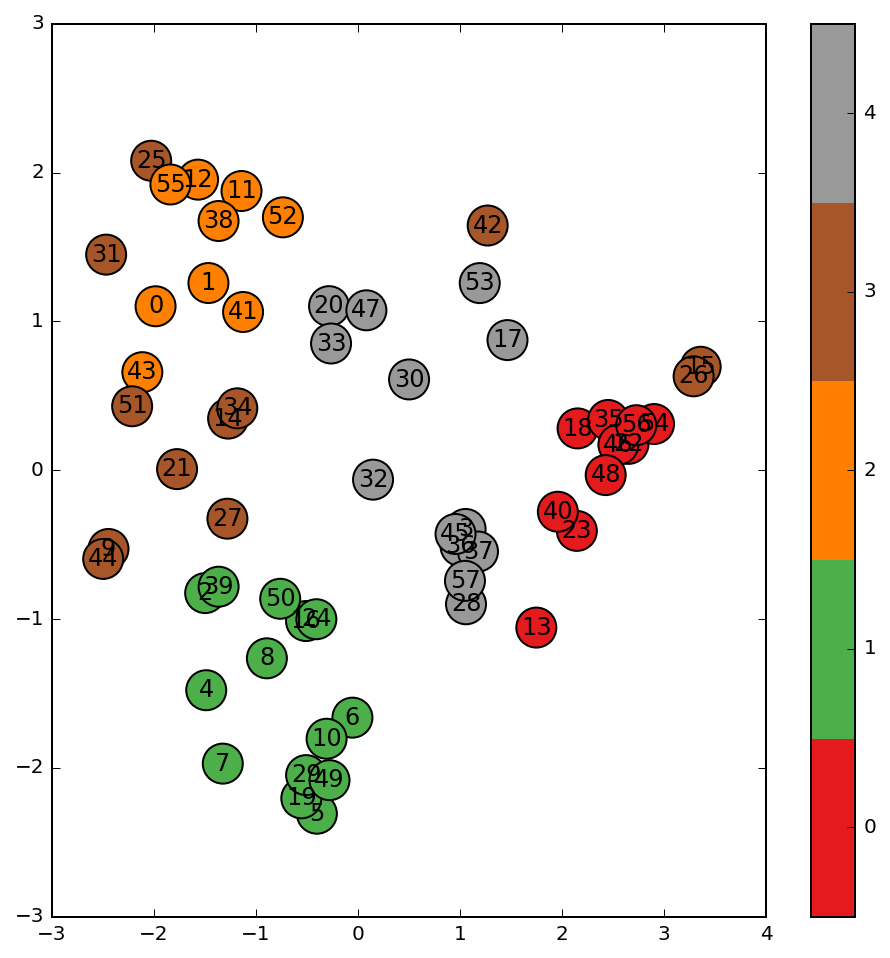

In [197]:
from sklearn.manifold import TSNE,LocallyLinearEmbedding
tsne = TSNE(n_components=2,verbose=1,perplexity=20.0
            ,init='pca' # random / pca
            ,n_iter=1000
            ,metric='euclidean' # euclidean / cosine / hamming / correlation
            ,random_state=10
            ,learning_rate=1.0) 
tsne_results = tsne.fit_transform(featHistTotal)

vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]
plt.figure(figsize=(8,8))
plt.scatter(vis_x,vis_y,c=childCluster
            ,cmap=plt.cm.get_cmap('Set1', 5),marker='o',s=400)
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i,0],tsne_results[i,1],s='%d'%(i)
             ,horizontalalignment='center'
             ,verticalalignment='center'
             ,fontsize=12)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 4.5)
plt.show()